In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(84).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(44).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(245).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/6.jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(238).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(196).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(108).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(310).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image (5).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(186).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(29).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(140).jpg
/kaggle/input/brain-tumor-classification-mri/Training/no_tumor/image(224).jpg

In [2]:
import keras
import keras.backend as K
import cv2
import pandas as pd
import seaborn as sns
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
from tqdm import tqdm
from IPython.display import SVG
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from time import time
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
import tensorflow.keras.backend as K

2024-04-11 12:33:33.755498: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-11 12:33:33.755632: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-11 12:33:33.886310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']

In [4]:
X_train = []
y_train = []
image_size = 150
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-classification-mri','Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_train.append(img)
        y_train.append(i)
        
X_train = np.array(X_train)
y_train = np.array(y_train)

100%|██████████| 74/74 [00:01<00:00, 73.69it/s]


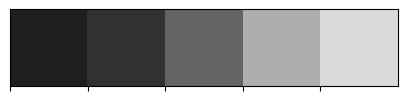

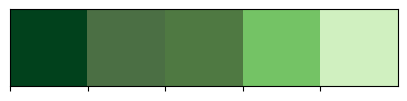

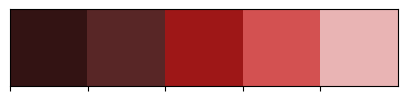

In [5]:
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_green = ['#01411C','#4B6F44','#4F7942','#74C365','#D0F0C0']

sns.palplot(colors_dark)
sns.palplot(colors_green)
sns.palplot(colors_red)

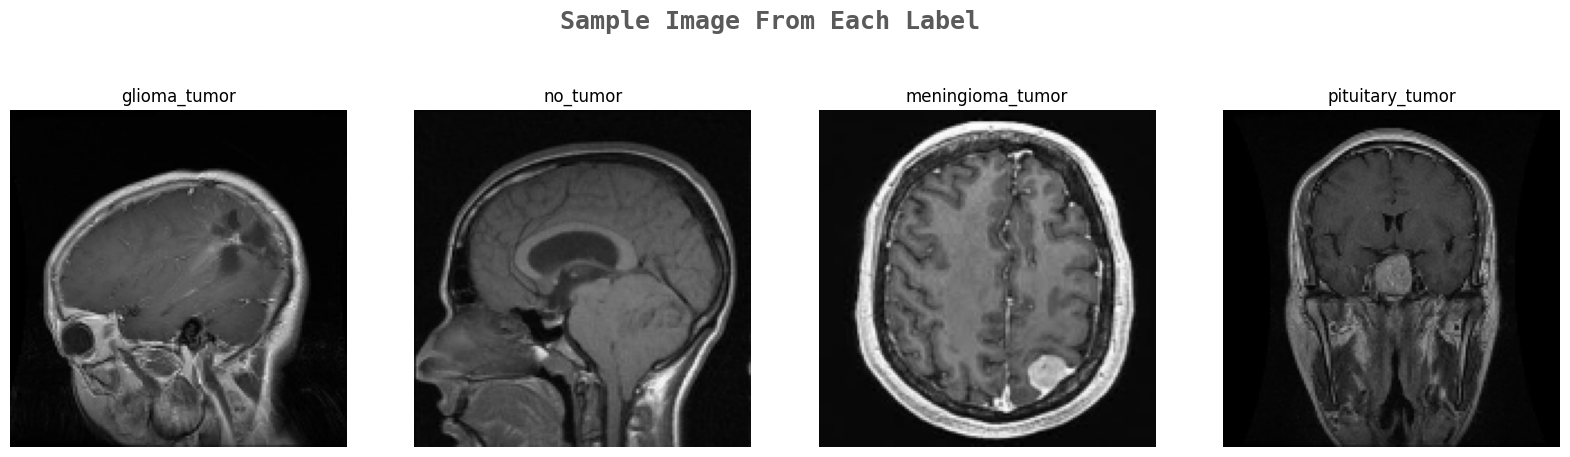

In [6]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train[j]==i:
            ax[k].imshow(X_train[j])
            ax[k].set_title(y_train[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [7]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

In [8]:
X_train.shape

(3264, 150, 150, 3)

In [9]:
y_train.shape

(3264,)

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

In [11]:
X_test.shape

(327, 150, 150, 3)

In [12]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_encoded = encoder.fit_transform(y_test.reshape(-1, 1)).toarray()

print(y_train_encoded.shape)
print(y_test_encoded.shape)

(2937, 4)
(327, 4)


In [13]:
y_train.shape

(2937,)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, DepthwiseConv2D, BatchNormalization, ReLU, GlobalAvgPool2D, Dense

def mobilenet(input_shape, n_classes):
    model = Sequential([
        Conv2D(32, 3, strides=2, padding='same', input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        
        mobilenet_block(64),
        mobilenet_block(128, strides=2),
        mobilenet_block(128),
        
        mobilenet_block(256, strides=2),
        mobilenet_block(256),
        
        mobilenet_block(512, strides=2),
        *[mobilenet_block(512) for _ in range(5)],
        
        mobilenet_block(1024, strides=2),
        mobilenet_block(1024),
        
        GlobalAvgPool2D(),
        
        Dense(n_classes, activation='softmax')
    ])
    return model

def mobilenet_block(filters, strides=1):
    return Sequential([
        DepthwiseConv2D(3, strides=strides, padding='same'),
        BatchNormalization(),
        ReLU(),
        Conv2D(filters, 1, strides=1, padding='same'),
        BatchNormalization(),
        ReLU()
    ])


model = mobilenet(input_shape=(224, 224, 3), n_classes=4)

        

In [16]:
img_shape = X_train.shape[1:]
n_classes = len(labels)


model = mobilenet(img_shape, n_classes)


model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])


history = model.fit(X_train, y_train_encoded, 
                    epochs=30, 
                    batch_size=32, 
                    validation_split=0.2)

Epoch 1/30
 3/74 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.2865 - loss: 1.5721  

I0000 00:00:1712840577.111665      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 ━━━━━━━━━━━━━━━━━━━━ 56s 320ms/step - accuracy: 0.4199 - loss: 1.3544 - val_accuracy: 0.2891 - val_loss: 1.5481
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.6282 - loss: 0.9228 - val_accuracy: 0.2840 - val_loss: 2.2389
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.7499 - loss: 0.6367 - val_accuracy: 0.2840 - val_loss: 2.6966
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8024 - loss: 0.5492 - val_accuracy: 0.2840 - val_loss: 3.6468
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8753 - loss: 0.3711 - val_accuracy: 0.2840 - val_loss: 4.6396
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8700 - loss: 0.3484 - val_accuracy: 0.2840 - val_loss: 5.4648
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.8654 - loss: 0.3334 - val_accuracy: 0.2840 - val_loss: 5.2194
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.9050 - loss: 0.2562 - val_accuracy: 0.2874 - val_loss: 

In [17]:
model.summary()

Model: "sequential_41"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 75, 75, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 75, 75, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_54 (ReLU)                 │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_28 (Sequential)      │ (None, 75, 75, 64)     │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_29 (Sequential)      │ (None, 38, 38, 128)    │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_30 (Sequential)      │ (None, 38, 38, 128)    │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_31 (Sequential)      │ (None, 19, 19, 256)    │        35,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_32 (Sequential)      │ (None, 19, 19, 256)    │        70,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_33 (Sequential)      │ (None, 10, 10, 512)    │       137,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_34 (Sequential)      │ (None, 10, 10, 512)    │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_35 (Sequential)      │ (None, 10, 10, 512)    │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_36 (Sequential)      │ (None, 10, 10, 512)    │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_37 (Sequential)      │ (None, 10, 10, 512)    │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_38 (Sequential)      │ (None, 10, 10, 512)    │       271,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_39 (Sequential)      │ (None, 5, 5, 1024)     │       536,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_40 (Sequential)      │ (None, 5, 5, 1024)     │     1,068,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,687,950 (36.96 MB)

 Trainable params: 3,222,020 (12.29 MB)

 Non-trainable params: 21,888 (85.50 KB)

 Optimizer params: 6,444,042 (24.58 MB)

In [18]:
def plot_training_curves(history):
    loss= np.array(history.history['loss'])
    val_loss= np.array(history.history['val_loss'])
    
    accuracy= np.array(history.history['accuracy'])
    val_accuracy= np.array(history.history['val_accuracy'])
    
    epochs= range(len(history.history['loss']))
    
    fig, (ax1, ax2)= plt.subplots(1,2,figsize=(10,3))
    
    #plot loss
    ax1.plot(epochs, loss, label='traing_loss', marker='o')
    
    ax1.plot(epochs, val_loss, label='val_loss', marker='o')
    
    ax1.fill_between(epochs,loss, val_loss, where=(loss>val_loss),color='C0',alpha=0.3,interpolate=True)
    ax1.fill_between(epochs,loss, val_loss, where=(loss<val_loss),color='C1',alpha=0.3,interpolate=True)
    
    ax1.set_title('Loss(Lower Means Better)',fontsize= 16)
    ax1.set_xlabel('Epochs', fontsize=10)
    
    ax1.legend()
    
    #plot Accuracy
    ax2.plot(epochs, accuracy, label='traing_accuracy', marker='o')
    
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='o')
    
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy>val_accuracy),color='C0',alpha=0.3,interpolate=True)
    ax2.fill_between(epochs,accuracy, val_accuracy, where=(accuracy<val_accuracy),color='C1',alpha=0.3,interpolate=True)
    
    ax2.set_title('Accuracy(Higher Means Better)',fontsize= 16)
    ax2.set_xlabel('Epochs', fontsize=10)
    
    ax2.legend()

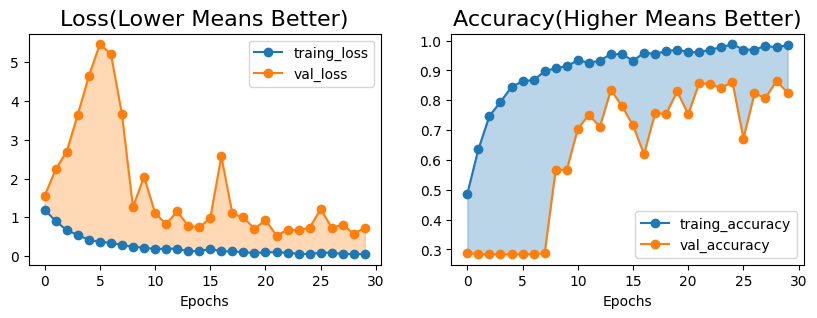

In [19]:
plot_training_curves(history)

In [20]:
xtest = X_test
ytest = y_test_encoded
ypred = model.predict(xtest)

total = len(ytest)
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
print('Total test data:', total)
print('Accurately predicted data:', accurate)
print('Wrongly predicted data:', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 264ms/step
Total test data: 327
Accurately predicted data: 269
Wrongly predicted data: 58
Accuracy: 82.263 %


# Визуализация правильных предсказаний модели

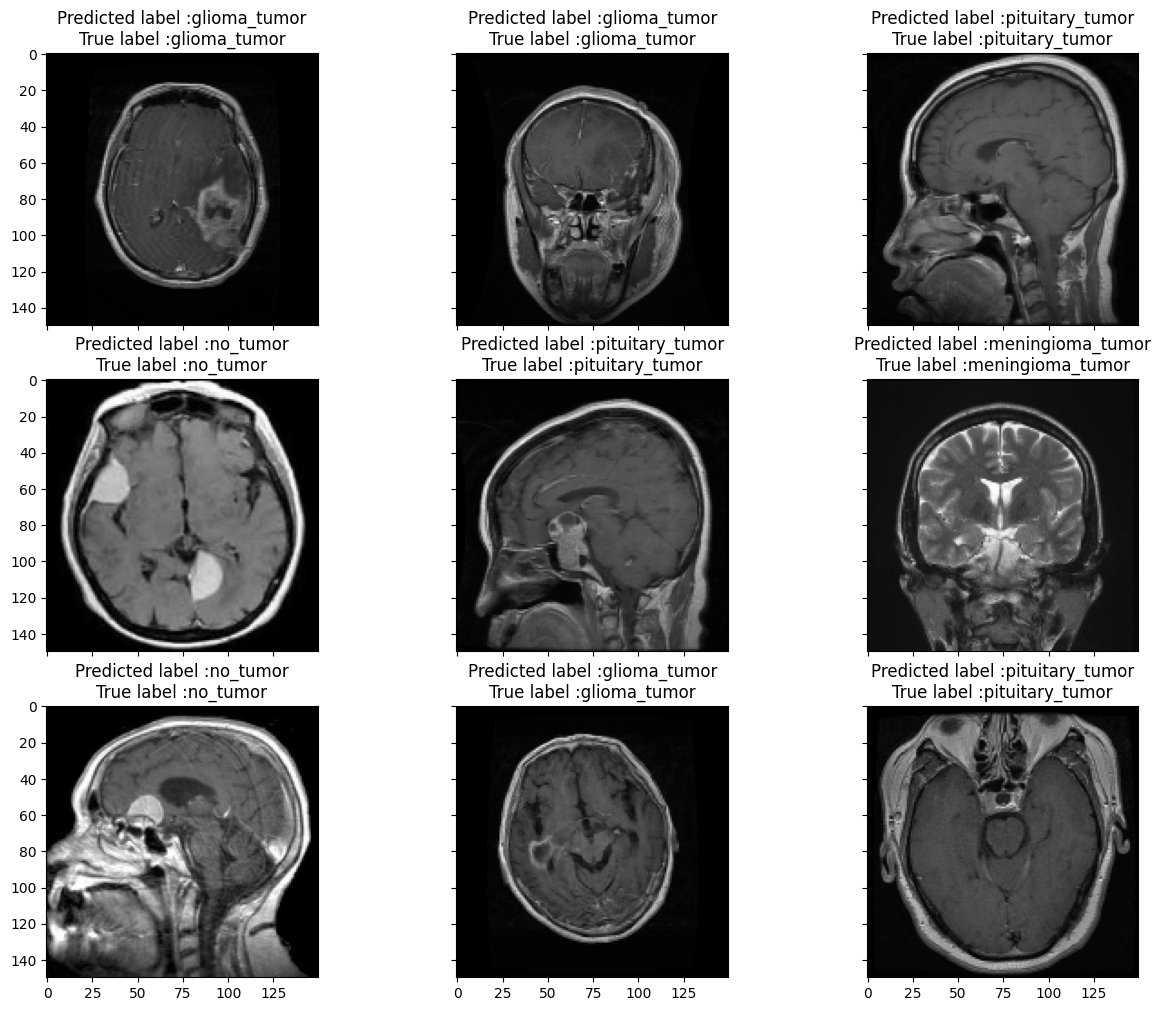

In [23]:
import random
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
imidx = random.sample(accurateindex, k=9)

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(labels[np.argmax(ypred[imidx[n]])], labels[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()

# Визуализация неправильных предсказаний модели

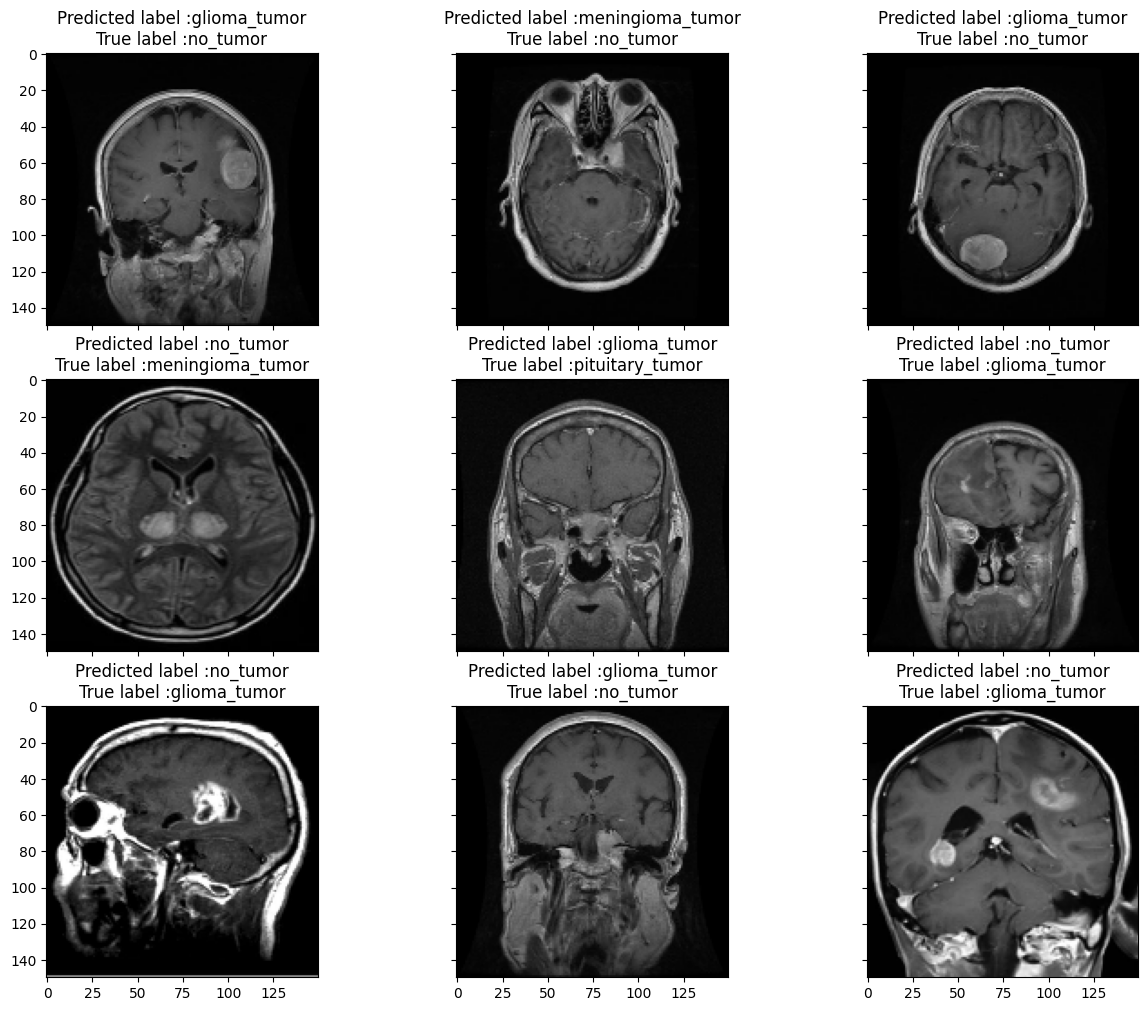

In [24]:
import random
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
imidx = random.sample(wrongindex, k=9)

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(labels[np.argmax(ypred[imidx[n]])], labels[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()